In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ga-customer-revenue-prediction/sample_submission.csv
/kaggle/input/ga-customer-revenue-prediction/train_v2.csv
/kaggle/input/ga-customer-revenue-prediction/test_v2.csv
/kaggle/input/ga-customer-revenue-prediction/sample_submission_v2.csv
/kaggle/input/ga-customer-revenue-prediction/train.csv
/kaggle/input/ga-customer-revenue-prediction/test.csv


# Part 0: Initialization


In [2]:
import numpy as np
import pandas as pd
import json
import os
from pandas import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline

from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = None

# Part 1: Prepossessing

In [3]:
# Load the dataset
data1 = pd.read_csv('/kaggle/input/ga-customer-revenue-prediction/train_v2.csv',dtype={"fullVisitorId": 'str'}, nrows = 2)
data1

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307


fullVisitorId- A unique identifier for each user of the Google Merchandise Store.

channelGrouping - The channel via which the user came to the Store.

date - The date on which the user visited the Store.

device - The specifications for the device used to access the Store.

geoNetwork - This section contains information about the geography of the user.

socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".

totals - This section contains aggregate values across the session.

trafficSource - This section contains information about the Traffic Source from which the session originated.

visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.

visitNumber - The session number for this user. If this is the first session, then this is set to 1.

visitStartTime - The timestamp (expressed as POSIX time).

hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.

customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.

totals - This set of columns mostly includes high-level aggregate data.

## Expanding Json data into Columns



In [4]:
def load_df(csv_path='/kaggle/input/ga-customer-revenue-prediction/train_v2.csv', nrows=900000):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,converters={column: json.loads for column in JSON_COLUMNS},dtype={'fullVisitorId': 'str'},nrows=nrows)
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    df.drop(columns = ['customDimensions','hits'],inplace=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

train = load_df()

Loaded train_v2.csv. Shape: (900000, 58)


In [5]:
# Display the first few rows of the resampled dataframe
train.head(1)

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,1,NaN,NaN,NaN,NaN,(not set),google,organic,water bottle,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Part 2.EDA

Only one unique value column?

In [6]:
# Identify columns with only one unique value
unique_columns = train.columns[train.nunique() == 1]

# Display the result
print("Columns with only one unique value:")
print(unique_columns)

Columns with only one unique value:
Index(['socialEngagementType', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystemVersion', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.bounces', 'totals.newVisits',
       'trafficSource.adwordsClickInfo.criteriaParameters',
       'trafficSource.isTrueDirect',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.campaignCode'],
      dtype='object')


In [7]:
train.drop(columns=unique_columns,inplace=True)

In [8]:
train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,Windows,False,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),1,1,1,NaN,NaN,NaN,NaN,(not set),google,organic,water bottle,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,(not set),2,2,2,28,NaN,NaN,NaN,(not set),sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,Android,True,mobile,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,2,2,1,38,NaN,NaN,NaN,(not set),(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,2,2,1,1,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,Windows,False,desktop,Americas,Central America,Mexico,not available in demo dataset,not available in demo dataset,not available in demo dataset,prod-infinitum.com.mx,2,2,1,52,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Define a regular expression pattern that matches any string containing 'not'
pattern = r'.*\bnot\b.*'

# Replace all occurrences of the pattern with NaN
train.replace(to_replace=pattern, value=np.nan, regex=True, inplace=True)

In [10]:
train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,Windows,False,desktop,Europe,Western Europe,Germany,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN,google,organic,water bottle,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,NaN,2,2,2,28,NaN,NaN,NaN,NaN,sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,Android,True,mobile,Americas,Northern America,United States,NaN,NaN,NaN,windjammercable.net,2,2,1,38,NaN,NaN,NaN,NaN,(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,NaN,NaN,NaN,unknown.unknown,2,2,1,1,NaN,NaN,NaN,NaN,google,organic,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,Windows,False,desktop,Americas,Central America,Mexico,NaN,NaN,NaN,prod-infinitum.com.mx,2,2,1,52,NaN,NaN,NaN,NaN,google,organic,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Duplicate rows?

In [11]:
train[train.duplicated(keep=False)]

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType


nan-containing columns? deal with them later

In [12]:
train.columns[train.isna().any()]

Index(['device.browser', 'device.operatingSystem', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'totals.pageviews', 'totals.sessionQualityDim', 'totals.timeOnSite',
       'totals.transactions', 'totals.transactionRevenue',
       'totals.totalTransactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType'],
      dtype='object')

In [13]:
train.columns[train.isna().all()]

Index([], dtype='object')

transaction rate

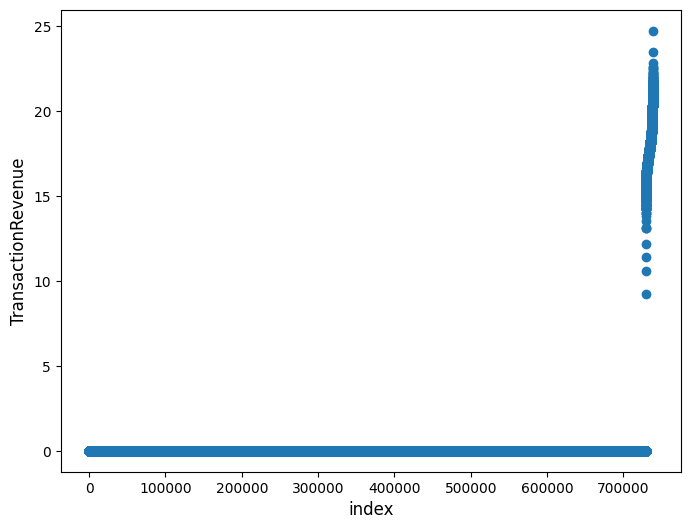

In [14]:
train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype('float')
gdf = train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))

# np.log1p is a function in NumPy that calculates the natural logarithm of one plus
# the input array elements. This function is particularly useful for numerical
# stability when the input values are very small.
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

We can see from the figure that only a very small portion of customers really spend the money and lots of people just randomly explore the store and quit. That's called the **80/20 rule** has proven true for many businesses - only a small percentage of customers produce most of the revenue. So what's the exact portion?

In [15]:
num_of_consumption_record = pd.notnull(train["totals.transactionRevenue"]).sum()
num_of_consumers = (gdf["totals.transactionRevenue"]>0).sum()

print("There are {} transaction records, accounting for {:.2f}% of the whole dataset".format(num_of_consumption_record, num_of_consumption_record/train.shape[0] * 100))
print("There are {} 'real customers', accounting for {:.2f}% of all customers".format(num_of_consumers, num_of_consumers/gdf.shape[0] * 100))

There are 9832 transaction records, accounting for 1.09% of the whole dataset
There are 8967 'real customers', accounting for 1.21% of all customers


Consumers make multiple purchases, but the overall percentage is small.

In [16]:
visitor_counts = train[train['totals.transactionRevenue'].notnull()]['fullVisitorId'].value_counts()

# Filter out the visitor IDs with counts greater than 1 (indicating multiple transactions)
multiple_transaction_users = visitor_counts[visitor_counts > 1]

# Extract the index (visitor IDs) of the filtered Series
multiple_transaction_user_ids = len(multiple_transaction_users.index)

print("{:.2f}% of customers made multiple transactions among customers who made transactions, that's {:.3f}% of all customers.".format(100*multiple_transaction_user_ids/num_of_consumers, 100*multiple_transaction_user_ids/gdf.shape[0]))

6.89% of customers made multiple transactions among customers who made transactions, that's 0.084% of all customers.


Visualize the relationship between views and consumption and provide conclusions.

**Tips:** groupby time, count transactionRevenue with NaN and without NaN.

## Date information

In [17]:
import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

# date format conversion from YYYYMMDD to YYYY-MM-DD
train['date'] = train['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [18]:
# size: It counts all rows in the group, including those with NaN values in totals.transactionRevenue.
# count: It only counts the rows where totals.transactionRevenue is not NaN.
cnt_srs = train.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])

cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = make_subplots(rows=2, cols=1, vertical_spacing=0.2,
                          subplot_titles=["Views", "Consumptions"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=400, width=800, plot_bgcolor = "rgb(233,233,233)", title="Date Plots")
py.iplot(fig, filename='date-plots')

**Conclusion:** There is no relationship between views and consumption, and the data can be divided into TRAIN and VALIDATION according to time period. The only pattern is that both of them present a certain periodicity.

## Session information

In [19]:
# Define line chart function
def line_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        mode='lines+markers',  # This includes both lines and markers
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

In [20]:
cnt_srs = train.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size', 'count', 'median','mean'])

cnt_srs.columns = ["count", "count of non-zero revenue","mean","median"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)

trace1 = scatter_plot(cnt_srs["count"].head(60), 'blue')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"].head(60), 'blue')
trace3 = scatter_plot(cnt_srs["mean"].head(60), 'blue')
trace4 = scatter_plot(cnt_srs["median"].head(60), 'blue')

cnt_srs = train.groupby('totals.hits')['totals.transactionRevenue'].agg(['size', 'count', 'median','mean'])

cnt_srs.columns = ["count", "count of non-zero revenue","mean","median"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
#cnt_srs.index = cnt_srs.index.astype('str')
trace5 = scatter_plot(cnt_srs["count"].head(60), 'red')
trace6 = scatter_plot(cnt_srs["count of non-zero revenue"].head(60), 'red')
trace7 = scatter_plot(cnt_srs["mean"].head(60), 'red')
trace8 = scatter_plot(cnt_srs["median"].head(60), 'red')

fig = make_subplots(rows=2, cols=4, vertical_spacing=0.2,
                          subplot_titles=["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count", "Total Pageviews - Mean Revenue","Total Pageviews - Median Revenue",
                                          "Total Hits - Count",  "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue","Total Hits - Median Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 1, 4)
fig.append_trace(trace5, 2, 1)
fig.append_trace(trace6, 2, 2)
fig.append_trace(trace7, 2, 3)
fig.append_trace(trace8, 2, 4)

fig['layout'].update(height=600, width=2000, plot_bgcolor = "rgb(233,233,233)", title="Session Plots")
py.iplot(fig, filename='session-plots')

## Device information

device.browser, device.operatingSystem, device.deviceCategory

In [21]:
cnt_srs = train.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'median','mean'])
cnt_srs.columns = ["count", "count of non-zero revenue","mean","median"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = scatter_plot(cnt_srs["count"].head(10), 'blue')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"].head(10), 'blue')
trace3 = scatter_plot(cnt_srs["mean"].head(10), 'blue')
trace4 = scatter_plot(cnt_srs["median"].head(10), 'blue')

cnt_srs = train.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'median','mean'])
cnt_srs.columns = ["count", "count of non-zero revenue","mean","median"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace5 = scatter_plot(cnt_srs["count"].head(10), 'red')
trace6 = scatter_plot(cnt_srs["count of non-zero revenue"].head(10), 'red')
trace7 = scatter_plot(cnt_srs["mean"].head(10), 'red')
trace8 = scatter_plot(cnt_srs["median"].head(10), 'red')

cnt_srs = train.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'median','mean'])
cnt_srs.columns = ["count", "count of non-zero revenue","mean","median"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace9 = scatter_plot(cnt_srs["count"].head(10), 'red')
trace10 = scatter_plot(cnt_srs["count of non-zero revenue"].head(10), 'red')
trace11 = scatter_plot(cnt_srs["mean"].head(10), 'red')
trace12 = scatter_plot(cnt_srs["median"].head(10), 'red')

fig = make_subplots(rows=3, cols=4, vertical_spacing=0.2,
                          subplot_titles=["Browser - Count", "Browser - Non-zero Revenue Count", "Browser - Mean Revenue","Browser - Median Revenue",
                                          "OS - Count",  "OS - Non-zero Revenue Count", "OS - Mean Revenue","OS - Median Revenue",
                                          "DeviceCategory - Count",  "DeviceCategory - Non-zero Revenue Count", "DeviceCategory - Mean Revenue","DeviceCategory - Median Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 1, 4)
fig.append_trace(trace5, 2, 1)
fig.append_trace(trace6, 2, 2)
fig.append_trace(trace7, 2, 3)
fig.append_trace(trace8, 2, 4)
fig.append_trace(trace9, 3, 1)
fig.append_trace(trace10, 3, 2)
fig.append_trace(trace11, 3, 3)
fig.append_trace(trace12, 3, 4)

fig['layout'].update(height=900, width=2000, plot_bgcolor = "rgb(233,233,233)", title="Device Plots")
py.iplot(fig, filename='session-plots')

## Geo information

geoNetwork.continent, geoNetwork.subContinent, geoNetwork.country, geoNetwork.region, geoNetwork.metro, geoNetwork.city, geoNetwork.networkDomain

In [22]:
cnt_srs = train.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'median','mean'])
cnt_srs.columns = ["count", "count of non-zero revenue","mean","median"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = scatter_plot(cnt_srs["count"].head(5), 'blue')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"].head(5), 'blue')
trace3 = scatter_plot(cnt_srs["mean"].head(5), 'blue')
trace4 = scatter_plot(cnt_srs["median"].head(5), 'blue')

cnt_srs = train.groupby('geoNetwork.country')['totals.transactionRevenue'].agg(['size', 'count', 'median','mean'])
cnt_srs.columns = ["count", "count of non-zero revenue","mean","median"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace5 = scatter_plot(cnt_srs["count"].head(10), 'red')
trace6 = scatter_plot(cnt_srs["count of non-zero revenue"].head(10), 'red')
trace7 = scatter_plot(cnt_srs["mean"].head(10), 'red')
trace8 = scatter_plot(cnt_srs["median"].head(10), 'red')

cnt_srs = train.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count', 'median','mean'])
cnt_srs.columns = ["count", "count of non-zero revenue","mean","median"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace9 = scatter_plot(cnt_srs["count"].head(10), 'red')
trace10 = scatter_plot(cnt_srs["count of non-zero revenue"].head(10), 'red')
trace11 = scatter_plot(cnt_srs["mean"].head(10), 'red')
trace12 = scatter_plot(cnt_srs["median"].head(10), 'red')

fig = make_subplots(rows=3, cols=4, vertical_spacing=0.2,
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue","Continent - Median Revenue",
                                          "Country - Count",  "Country - Non-zero Revenue Count", "Country - Mean Revenue","Country - Median Revenue",
                                          "NetworkDomain - Count",  "NetworkDomain - Non-zero Revenue Count", "NetworkDomain - Mean Revenue","NetworkDomain - Median Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 1, 4)
fig.append_trace(trace5, 2, 1)
fig.append_trace(trace6, 2, 2)
fig.append_trace(trace7, 2, 3)
fig.append_trace(trace8, 2, 4)
fig.append_trace(trace9, 3, 1)
fig.append_trace(trace10, 3, 2)
fig.append_trace(trace11, 3, 3)
fig.append_trace(trace12, 3, 4)

fig['layout'].update(height=900, width=2000, plot_bgcolor = "rgb(233,233,233)", title="Geo Plots")
py.iplot(fig, filename='session-plots')

## Traffic source information

trafficSource.campaign, trafficSource.source, trafficSource.medium, trafficSource.keyword, trafficSource.referralPath, trafficSource.adwordsClickInfo.page, trafficSource.adwordsClickInfo.slot, trafficSource.adwordsClickInfo.gclId, trafficSource.adwordsClickInfo.adNetworkType, trafficSource.adContent

In [23]:
cnt_srs = train.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'median','mean'])
cnt_srs.columns = ["count", "count of non-zero revenue","mean","median"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = scatter_plot(cnt_srs["count"].head(5), 'blue')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"].head(5), 'blue')
trace3 = scatter_plot(cnt_srs["mean"].head(5), 'blue')
trace4 = scatter_plot(cnt_srs["median"].head(5), 'blue')

cnt_srs = train.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'median','mean'])
cnt_srs.columns = ["count", "count of non-zero revenue","mean","median"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace5 = scatter_plot(cnt_srs["count"].head(10), 'red')
trace6 = scatter_plot(cnt_srs["count of non-zero revenue"].head(10), 'red')
trace7 = scatter_plot(cnt_srs["mean"].head(10), 'red')
trace8 = scatter_plot(cnt_srs["median"].head(10), 'red')



fig = make_subplots(rows=2, cols=4, vertical_spacing=0.2,
                          subplot_titles=["Source - Count", "Source - Non-zero Revenue Count", "Source - Mean Revenue","Source - Median Revenue",
                                          "Medium - Count",  "Country - Non-zero Revenue Count", "Country - Mean Revenue","Country - Median Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 1, 4)
fig.append_trace(trace5, 2, 1)
fig.append_trace(trace6, 2, 2)
fig.append_trace(trace7, 2, 3)
fig.append_trace(trace8, 2, 4)


fig['layout'].update(height=900, width=2000, plot_bgcolor = "rgb(233,233,233)", title="Traffic Source Plots")
py.iplot(fig, filename='session-plots')

# Part 3. Feature Engineering

In [24]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.operatingSystem',
       'device.isMobile', 'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'totals.hits', 'totals.pageviews', 'totals.sessionQualityDim',
       'totals.timeOnSite', 'totals.transactions', 'totals.transactionRevenue',
       'totals.totalTransactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType'],
      dtype='object')

In [25]:
# train['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
# train['trafficSource.isTrueDirect'].fillna(False, inplace=True)

# # remove columns with only one distinct value
# cols_to_drop = [col for col in train.columns if train[col].nunique(dropna=False) == 1]
# train.drop(cols_to_drop, axis=1, inplace=True)

# #only one not null value
# train.drop(['trafficSource.campaignCode'], axis=1, inplace=True)

train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1,1508198450,Firefox,Windows,False,desktop,Europe,Western Europe,Germany,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN,google,organic,water bottle,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,2017-10-16,8934116514970143966,1508176307,6,1508176307,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,NaN,2,2,2,28,NaN,NaN,NaN,NaN,sites.google.com,referral,NaN,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN
2,Direct,2017-10-16,7992466427990357681,1508201613,1,1508201613,Chrome,Android,True,mobile,Americas,Northern America,United States,NaN,NaN,NaN,windjammercable.net,2,2,1,38,NaN,NaN,NaN,NaN,(direct),(none),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,2017-10-16,9075655783635761930,1508169851,1,1508169851,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,NaN,NaN,NaN,unknown.unknown,2,2,1,1,NaN,NaN,NaN,NaN,google,organic,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,2017-10-16,6960673291025684308,1508190552,1,1508190552,Chrome,Windows,False,desktop,Americas,Central America,Mexico,NaN,NaN,NaN,prod-infinitum.com.mx,2,2,1,52,NaN,NaN,NaN,NaN,google,organic,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Smoothing operation using np.log1p method for numerical features.




In [26]:
train.dtypes

channelGrouping                                  object
date                                             object
fullVisitorId                                    object
visitId                                           int64
visitNumber                                       int64
visitStartTime                                    int64
device.browser                                   object
device.operatingSystem                           object
device.isMobile                                    bool
device.deviceCategory                            object
geoNetwork.continent                             object
geoNetwork.subContinent                          object
geoNetwork.country                               object
geoNetwork.region                                object
geoNetwork.metro                                 object
geoNetwork.city                                  object
geoNetwork.networkDomain                         object
totals.hits                                     

In [27]:
num_cols = ['visitNumber', 'totals.hits', 'totals.pageviews', 'totals.sessionQualityDim', 'totals.timeOnSite', 'totals.transactionRevenue']
# num_cols = ['visitNumber', 'totals.hits', 'totals.pageviews', 'totals.transactionRevenue']
for col in num_cols:
    train[col] = train[col].fillna(0)
    train[col] = train[col].astype(float)
    train[col] = np.log1p(train[col])

Otherwise, just make up the zeros.

In [28]:
train.columns[train.isna().any()]

Index(['device.browser', 'device.operatingSystem', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'totals.transactions', 'totals.totalTransactionRevenue',
       'trafficSource.campaign', 'trafficSource.source',
       'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType'],
      dtype='object')

In [29]:
# Identify columns with NaN values
cols_with_nan = train.columns[train.isna().any()]

# Fill NaN values with 0 in those columns
train[cols_with_nan] = train[cols_with_nan].fillna(0)

# train['trafficSource.adContent'] = train['trafficSource.adContent'].fillna(0)
# train['trafficSource.keyword'] = train['trafficSource.keyword'].fillna(0)
# train['trafficSource.adwordsClickInfo.adNetworkType'] = train['trafficSource.adwordsClickInfo.adNetworkType'].fillna(0)
# train['trafficSource.adwordsClickInfo.gclId'] = train['trafficSource.adwordsClickInfo.gclId'].fillna(0)
# train['trafficSource.adwordsClickInfo.page'] = train['trafficSource.adwordsClickInfo.page'].fillna(0)
# train['trafficSource.adwordsClickInfo.slot'] = train['trafficSource.adwordsClickInfo.slot'].fillna(0)




Create new columns to add features

In [30]:
# train['browser_category'] = train['device.browser'] + '_' + train['device.deviceCategory']
# train['browser_operatingSystem'] = train['device.browser'] + '_' + train['device.operatingSystem']
# train['source_country'] = train['trafficSource.source'] + '_' + train['geoNetwork.country']


Remove unused columns

In [31]:
no_use = ["date", "fullVisitorId", "sessionId", "visitId", "visitStartTime", 'totals.transactionRevenue', 'trafficSource.referralPath']
cat_cols = [col for col in train.columns if col not in num_cols and col not in no_use]


Label Encoding:

In [32]:
max_values = {}
for col in cat_cols:
    print(col)
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    max_values[col] = train[col].max() + 2
    # The addition of 2 ensures there is a gap (possibly for future encoding or
    # to handle unseen categories during model inference).

channelGrouping
device.browser
device.operatingSystem
device.isMobile
device.deviceCategory
geoNetwork.continent
geoNetwork.subContinent
geoNetwork.country
geoNetwork.region
geoNetwork.metro
geoNetwork.city
geoNetwork.networkDomain
totals.transactions
totals.totalTransactionRevenue
trafficSource.campaign
trafficSource.source
trafficSource.medium
trafficSource.keyword
trafficSource.adContent
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.adNetworkType


In [33]:
max_values

{'channelGrouping': 9,
 'device.browser': 83,
 'device.operatingSystem': 25,
 'device.isMobile': 3,
 'device.deviceCategory': 4,
 'geoNetwork.continent': 7,
 'geoNetwork.subContinent': 24,
 'geoNetwork.country': 223,
 'geoNetwork.region': 434,
 'geoNetwork.metro': 107,
 'geoNetwork.city': 771,
 'geoNetwork.networkDomain': 29571,
 'totals.transactions': 10,
 'totals.totalTransactionRevenue': 5363,
 'trafficSource.campaign': 33,
 'trafficSource.source': 287,
 'trafficSource.medium': 8,
 'trafficSource.keyword': 2660,
 'trafficSource.adContent': 76,
 'trafficSource.adwordsClickInfo.page': 12,
 'trafficSource.adwordsClickInfo.slot': 5,
 'trafficSource.adwordsClickInfo.gclId': 32011,
 'trafficSource.adwordsClickInfo.adNetworkType': 5}

According to the size of Embedding, Categories are divided into 2 categories, one with vocabulary less than 50 and one with vocabulary more than 50.

Subsequently, the NN network is processed in 2 branches, and the parameters of large vocabulary are set as 2 times of small vocabulary parameters.

In [34]:
# Initialize lists to hold the keys
cat_col_labels1 = []
cat_col_labels2 = []

# Iterate through the dictionary and classify the keys
for key, value in max_values.items():
    if value > 25:
        cat_col_labels2.append(key)
    else:
        cat_col_labels1.append(key)
        
# cat_col_labels1 = ["channelGrouping", "device.deviceCategory", "device.operatingSystem", "geoNetwork.continent",
#                    "geoNetwork.subContinent", "trafficSource.adContent", "trafficSource.adwordsClickInfo.adNetworkType",
#                    "trafficSource.adwordsClickInfo.isVideoAd", "trafficSource.adwordsClickInfo.page", "trafficSource.adwordsClickInfo.slot",
#                    "trafficSource.campaign", "trafficSource.medium", "geoNetwork.region"]

# cat_col_labels2 = ["browser_category", "browser_operatingSystem", "source_country", "device.browser", "geoNetwork.city",
#                    "trafficSource.source", "trafficSource.keyword", "trafficSource.adwordsClickInfo.gclId", "geoNetwork.networkDomain",
#                    "geoNetwork.country", "geoNetwork.metro", "geoNetwork.region"]

# Part 4. Data preparation (last 2 months of data as validation)

In [35]:
train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,4,2017-10-16,3162355547410993243,1508198450,0.693147,1508198450,32,20,0,0,4,22,73,0,0,1,0,0.693147,0.693147,0.693147,0.000000,0,0.0,0,4,84,5,1948,0,0,0,0,0,0
1,6,2017-10-16,8934116514970143966,1508176307,1.945910,1508176307,25,3,0,0,2,12,212,67,88,170,0,1.098612,1.098612,1.098612,3.367296,0,0.0,0,4,250,6,68,/a/google.com/transportation/mtv-services/bike...,0,0,0,0,0
2,2,2017-10-16,7992466427990357681,1508201613,0.693147,1508201613,25,1,1,1,2,12,212,0,0,1,28822,1.098612,1.098612,0.693147,3.663562,0,0.0,0,4,0,0,68,0,0,0,0,0,0
3,4,2017-10-16,9075655783635761930,1508169851,0.693147,1508169851,25,20,0,0,3,21,204,0,0,1,27187,1.098612,1.098612,0.693147,0.693147,0,0.0,0,4,84,5,68,0,0,0,0,0,0
4,4,2017-10-16,6960673291025684308,1508190552,0.693147,1508190552,25,20,0,0,2,3,129,0,0,1,20465,1.098612,1.098612,0.693147,3.970292,0,0.0,0,4,84,5,68,0,0,0,0,0,0


In [36]:
cols_to_drop = ['fullVisitorId', 'visitId','visitStartTime','trafficSource.referralPath']  # List of column names to drop
train.drop(cols_to_drop, axis=1, inplace=True)
train.head()

,channelGrouping,date,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,4,2017-10-16,0.693147,32,20,0,0,4,22,73,0,0,1,0,0.693147,0.693147,0.693147,0.000000,0,0.0,0,4,84,5,1948,0,0,0,0,0
1,6,2017-10-16,1.945910,25,3,0,0,2,12,212,67,88,170,0,1.098612,1.098612,1.098612,3.367296,0,0.0,0,4,250,6,68,0,0,0,0,0
2,2,2017-10-16,0.693147,25,1,1,1,2,12,212,0,0,1,28822,1.098612,1.098612,0.693147,3.663562,0,0.0,0,4,0,0,68,0,0,0,0,0
3,4,2017-10-16,0.693147,25,20,0,0,3,21,204,0,0,1,27187,1.098612,1.098612,0.693147,0.693147,0,0.0,0,4,84,5,68,0,0,0,0,0
4,4,2017-10-16,0.693147,25,20,0,0,2,3,129,0,0,1,20465,1.098612,1.098612,0.693147,3.970292,0,0.0,0,4,84,5,68,0,0,0,0,0


In [37]:
train['date'].max(), train['date'].min()

(datetime.date(2018, 4, 29), datetime.date(2016, 8, 2))

In [38]:
import datetime
from sklearn.model_selection import train_test_split

train['date'] = pd.to_datetime(train['date'])

train = train.sort_values('date')

# Target variable
y = train['totals.transactionRevenue']

# Assuming 'no_use' is a list of columns to drop
no_use = ['totals.transactionRevenue']

# Drop unused columns
X = train.drop(no_use, axis=1)

# Split the data into training and validation sets with an 80-20 ratio
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# # Split the data into training and validation sets
# split_date = pd.Timestamp(2017, 5, 31)

# x_train = train[train['date'] <= split_date]
# x_val = train[train['date'] > split_date]

# # Target variable
# y_train = x_train['totals.transactionRevenue']
# y_val = x_val['totals.transactionRevenue']

# # Assuming 'no_use' is a list of columns to drop
# no_use = ['totals.transactionRevenue']

# # Drop unused columns
# x_train = x_train.drop(no_use, axis=1)
# x_val = x_val.drop(no_use, axis=1)

In [39]:
X_train.drop('date', axis=1, inplace=True)
X_val.drop('date', axis=1, inplace=True)

# Part 5.Model Part

## LGB model

In [40]:
# import lightgbm as lgb
# from sklearn.metrics import mean_squared_error

# # Create datasets for LightGBM
# train_data = lgb.Dataset(X_train, label=y_train)
# val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# # Define parameters
# params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'boosting_type': 'gbdt',
#     'learning_rate': 0.1,
#     'num_leaves': 31,
#     'verbose': 0,
#     'early_stopping_rounds': 10  # Correct parameter name for early stopping
# }

# # Train the model
# model = lgb.train(
#     params,
#     train_data,
#     num_boost_round=100,
#     valid_sets=[train_data, val_data],
#     valid_names=['train', 'valid'],
# )

# # Predict
# y_pred = model.predict(X_val, num_iteration=model.best_iteration)

# # Evaluate
# rmse = mean_squared_error(y_val, y_pred, squared=False)
# print(f'RMSE: {rmse}')

# # Get evaluation results
# train_metric = model.evals_result_['train']['rmse']
# val_metric = model.evals_result_['valid']['rmse']
# x_axis = range(len(train_metric))

# # Plot training and validation RMSE
# plt.figure(figsize=(10, 5))
# plt.plot(x_axis, train_metric, label='Train')
# plt.plot(x_axis, val_metric, label='Validation')
# plt.legend()
# plt.xlabel('Boosting Round')
# plt.ylabel('RMSE')
# plt.title('Training and Validation RMSE')
# plt.show()

import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Define LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': -1
}

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Train the LightGBM model
num_round = 1000
bst = lgb.train(params, train_data, num_round, valid_sets=[val_data])

# Make predictions on the validation data
y_pred = bst.predict(X_val, num_iteration=bst.best_iteration)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred) 
print("MSE on validation data:", mse)

MSE on validation data: 0.012289438199222985


## Deep model

In [41]:
# import datetime

# train['date'] = pd.to_datetime(train['date'])

# train = train.sort_values('date')

# # Split the data into training and validation sets
# split_date = pd.Timestamp(2017, 5, 31)

# x_train = train[train['date'] <= split_date]
# x_val = train[train['date'] > split_date]

# # Target variable
# y_train = x_train['totals.transactionRevenue']
# y_val = x_val['totals.transactionRevenue']

# # Assuming 'no_use' is a list of columns to drop
# no_use = ['totals.transactionRevenue']

# # Drop unused columns
# x_train = x_train.drop(no_use, axis=1)
# x_val = x_val.drop(no_use, axis=1)

In [42]:
num_cols.remove("totals.transactionRevenue")
num_cols

['visitNumber',
 'totals.hits',
 'totals.pageviews',
 'totals.sessionQualityDim',
 'totals.timeOnSite']

Compute embedding dimension for each category column.

https://www.youtube.com/watch?v=gbceqO8PpBg&t=3357s

https://forums.fast.ai/t/size-of-embedding-for-categorical-variables/42608/2

In [43]:
emb_dims1 = []
emb_dims2 = []
for i in cat_col_labels1:
    emb_dims1.append((max_values[i], min((max_values[i]+1)//2, 50)))
for i in cat_col_labels2:
    emb_dims2.append((max_values[i], min((max_values[i]+1)//2, 50)))

In [44]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

Customize TabularDataset, inheriting from DataSet, to return the desired data based on our dataset

In [45]:
class TabularDataset(Dataset):
    def __init__(self, x_data, y_data, cat_cols1, cat_cols2, num_cols):

        """
        data: pandas data frame;
        cat_cols: list of string, the names of the categorical columns in the data,
        will be passed through the embedding layers;
        num_cols: list of string;
        y_data: the target;
        """

        self.n = x_data.shape[0]
        self.y = y_data.astype(np.float32).values.reshape(-1, 1)

        self.cat_cols1 = cat_cols1
        self.cat_cols2 = cat_cols2
        self.num_cols = num_cols

        self.num_X = x_data[self.num_cols].astype(np.float32).values
        self.cat_X1 = x_data[self.cat_cols1].astype(np.int64).values
        self.cat_X2 = x_data[self.cat_cols2].astype(np.int64).values


    def print_data(self):
        return self.num_X, self.cat_X1, self.cat_X2, self.y

    def __len__(self):
        """
        total number of samples
        """
        return self.n

    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        return [self.y[idx], self.num_X[idx], self.cat_X1[idx], self.cat_X2[idx]]

NN network (2 branches --> branch merge --> main branch)

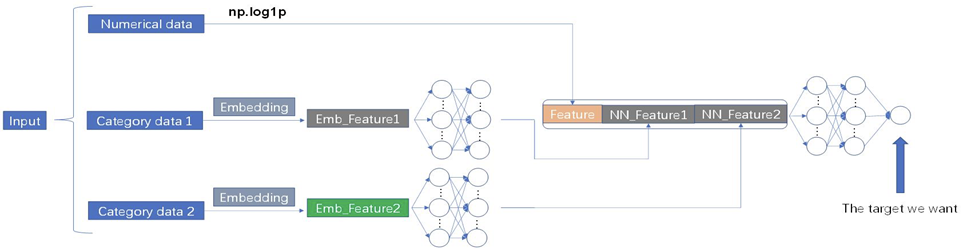

In [46]:
class FeedForwardNN(nn.Module):
    def __init__(self, emb_dims1, emb_dims2, no_of_num, lin_layer_sizes, output_size, \
                 emb_dropout, lin_layer_dropouts):
        """
        emb_dims:           List of two element tuples;
        no_of_num:          Integer, the number of continuous features in the data;
        lin_layer_sizes:    List of integers. The size of each linear layer;
        output_size:        Integer, the size of the final output;
        emb_dropout:        Float, the dropout to be used after the embedding layers.
        lin_layer_dropouts: List of floats, the dropouts to be used after each linear layer.
        """
        super().__init__()

        # embedding layers
        # torch.nn.Embedding(num_embeddings/the number of unique categories in each feature,
        # embedding_dim/the dimension of the dense vector representing each category)
        self.emb_layers1 = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims1])
        self.emb_layers2 = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims2])

        # Calculate the number of individual embedding parameters in preparation
        # for subsequent Linear layer inputs
        self.no_of_embs1 = sum([y for x, y in emb_dims1])
        self.no_of_embs2 = sum([y for x, y in emb_dims2])
        self.no_of_num = no_of_num

        # branch 1
        self.branch1 = nn.Linear(self.no_of_embs1, lin_layer_sizes[0])
        self.branch1_2 = nn.Linear(lin_layer_sizes[0], lin_layer_sizes[1])
        nn.init.kaiming_normal_(self.branch1.weight.data)
        nn.init.kaiming_normal_(self.branch1_2.weight.data)

        # branch 2
        self.branch2 = nn.Linear(self.no_of_embs2, lin_layer_sizes[0] * 2)
        self.branch2_2 = nn.Linear(lin_layer_sizes[0] * 2, lin_layer_sizes[1] * 2)
        nn.init.kaiming_normal_(self.branch2.weight.data)
        nn.init.kaiming_normal_(self.branch2_2.weight.data)

        # main branch
        self.main_layer1 = nn.Linear(lin_layer_sizes[1] * 3 + self.no_of_num, lin_layer_sizes[2])
        self.main_layer2 = nn.Linear(lin_layer_sizes[2], lin_layer_sizes[3])

        # batch normal
        self.branch_bn_layers1 = nn.BatchNorm1d(lin_layer_sizes[0])
        self.branch_bn_layers2 = nn.BatchNorm1d(lin_layer_sizes[0] * 2)
        self.main_bn_layer = nn.BatchNorm1d(lin_layer_sizes[2])

        # Dropout Layers
        self.emb_dropout_layer = nn.Dropout(emb_dropout)
        self.dropout_layers = nn.ModuleList([nn.Dropout(size) for size in lin_layer_dropouts])

        # Output layer
        self.output_layer = nn.Linear(lin_layer_sizes[-1], output_size)
        nn.init.kaiming_normal_(self.output_layer.weight.data)

    def forward(self, num_data, cat_data1, cat_data2):

        # embedding categorical feature and cat them together
        x1 = [emb_layer(cat_data1[:, i].clone().detach()) for i, emb_layer in enumerate(self.emb_layers1)]
        x1 = torch.cat(x1, 1)

        x1 = self.emb_dropout_layer(F.relu(self.branch1(x1)))
        x1 = self.branch_bn_layers1(x1)
        x1 = self.dropout_layers[0](F.relu(self.branch1_2(x1)))


        x2 = [emb_layer(cat_data2[:, i].clone().detach()) for i, emb_layer in enumerate(self.emb_layers2)]
        x2 = torch.cat(x2, 1)

        x2 = self.emb_dropout_layer(F.relu(self.branch2(x2)))
        x2 = self.branch_bn_layers2(x2)
        x2 = self.dropout_layers[0](F.relu(self.branch2_2(x2)))

        main = torch.cat([x1, x2, num_data], 1)

        main = self.dropout_layers[1](F.relu(self.main_layer1(main)))
        main = self.main_bn_layer(main)
        main = self.dropout_layers[2](F.relu(self.main_layer2(main)))

        out = self.output_layer(main)
        return out

In [47]:
train_dataset = TabularDataset(x_data=X_train, y_data=y_train, cat_cols1=cat_col_labels1, cat_cols2=cat_col_labels2, num_cols=num_cols)
val_dataset = TabularDataset(x_data=X_val, y_data=y_val, cat_cols1=cat_col_labels1, cat_cols2=cat_col_labels2, num_cols=num_cols)

In [48]:
batchsize = 64
train_dataloader = DataLoader(train_dataset, batchsize, shuffle=True, num_workers=0)
val_dataloder = DataLoader(val_dataset, 64, shuffle=True, num_workers=0)

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeedForwardNN(emb_dims1=emb_dims1,
                      emb_dims2=emb_dims2,
                      no_of_num=len(num_cols),
                      lin_layer_sizes=[128,64,32,16],
                      output_size=1,
                      lin_layer_dropouts=[0.1, 0.1, 0.05],
                      emb_dropout=0.05).to(device)

#### training

In [50]:
no_of_epochs = 20
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
total_data = train_dataset.__len__()

print_every = 500
steps = 0
running_loss = 0
for epoch in range(no_of_epochs):
    model.train()
    for index, datas in enumerate(train_dataloader):
        steps += 1
        y, num_x, cat_x1, cat_x2 = datas
        cat_x1 = cat_x1.to(device)
        cat_x2 = cat_x2.to(device)
        num_x = num_x.to(device)
        y  = y.to(device)

        # Forward Pass
        optimizer.zero_grad()
        preds = model.forward(num_x, cat_x1, cat_x2)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if steps % print_every == 0:
            val_loss = 0
            model.eval()
            with torch.no_grad():
                for val_index, val_datas in enumerate(val_dataloder):
                    y, num_x, cat_x1, cat_x2 = val_datas
                    cat_x1 = cat_x1.to(device)
                    cat_x2 = cat_x2.to(device)
                    num_x = num_x.to(device)
                    y  = y.to(device)

                    out = model.forward(num_x, cat_x1, cat_x2)
                    batch_loss = criterion(out, y)
                    val_loss += batch_loss.item()

    print(f"Epoch {epoch+1}/{no_of_epochs}.."
              f"Train loss:{running_loss/print_every:.3f}.."
              f"Validation loss:{val_loss/len(val_dataloder):.3f}..")
    running_loss = 0
    model.train()

Epoch 1/20..Train loss:3.531..Validation loss:0.017..
Epoch 2/20..Train loss:0.938..Validation loss:0.016..
Epoch 3/20..Train loss:0.903..Validation loss:0.024..
Epoch 4/20..Train loss:0.947..Validation loss:0.018..
Epoch 5/20..Train loss:0.898..Validation loss:0.017..
Epoch 6/20..Train loss:1.098..Validation loss:0.022..
Epoch 7/20..Train loss:0.641..Validation loss:0.015..
Epoch 8/20..Train loss:0.600..Validation loss:0.015..
Epoch 9/20..Train loss:0.505..Validation loss:0.015..
Epoch 10/20..Train loss:0.372..Validation loss:0.017..
Epoch 11/20..Train loss:0.464..Validation loss:0.013..
Epoch 12/20..Train loss:0.359..Validation loss:0.013..
Epoch 13/20..Train loss:0.425..Validation loss:0.013..
Epoch 14/20..Train loss:0.344..Validation loss:0.013..
Epoch 15/20..Train loss:0.413..Validation loss:0.015..
Epoch 16/20..Train loss:0.316..Validation loss:0.013..
Epoch 17/20..Train loss:0.334..Validation loss:0.014..
Epoch 18/20..Train loss:0.293..Validation loss:0.014..
Epoch 19/20..Train 

## Lift model

As previously stated, only a small portion of people can bring profits to the company. So one important aspect is to enhance marketing strategies and target the right segments. Here I will use a concept called lift to guide me through this. Don't forget that our dataset is highly imbalanced. So maybe some sampling techniques may be applied.

In [51]:
train = train[train['totals.transactionRevenue'] != 0.0]

In [62]:
# Target variable
y = train['totals.transactionRevenue']

# Assuming 'no_use' is a list of columns to drop
no_use = ['totals.transactionRevenue']

# Drop unused columns
X = train.drop(no_use, axis=1)

# Split the data into training and validation sets with an 80-20 ratio
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.drop('date', axis=1, inplace=True)
X_val.drop('date', axis=1, inplace=True)

In [63]:
from sklearn.ensemble import RandomForestRegressor

In [64]:
# Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [65]:
# Predict revenue
y_pred = model.predict(X_val)

# Create a DataFrame with actual and predicted values
results = pd.DataFrame({'actual': y_val, 'predicted': y_pred})

In [66]:
results

,actual,predicted
725481,17.118360,17.421867
330734,18.221986,18.196364
202308,16.972085,17.293208
250851,17.457298,17.566585
780698,17.617049,17.873050
...,...,...
32567,16.906098,16.898726
25899,16.587474,16.694517
566467,17.682536,17.953885
719925,17.341283,17.964070


In [67]:
np.mean((results['actual'] - results['predicted']) ** 2)

1.0305793334842388

In [68]:
# Calculate deciles
results['decile'] = pd.qcut(results['predicted'], 10, labels=False)

# Calculate average actual price per decile
lift = results.groupby('decile')['actual'].mean()

print(lift)

decile
0    16.829388
1    17.156547
2    17.557623
3    17.652631
4    17.698821
5    17.846018
6    17.946258
7    18.083449
8    18.345842
9    18.838526
Name: actual, dtype: float64


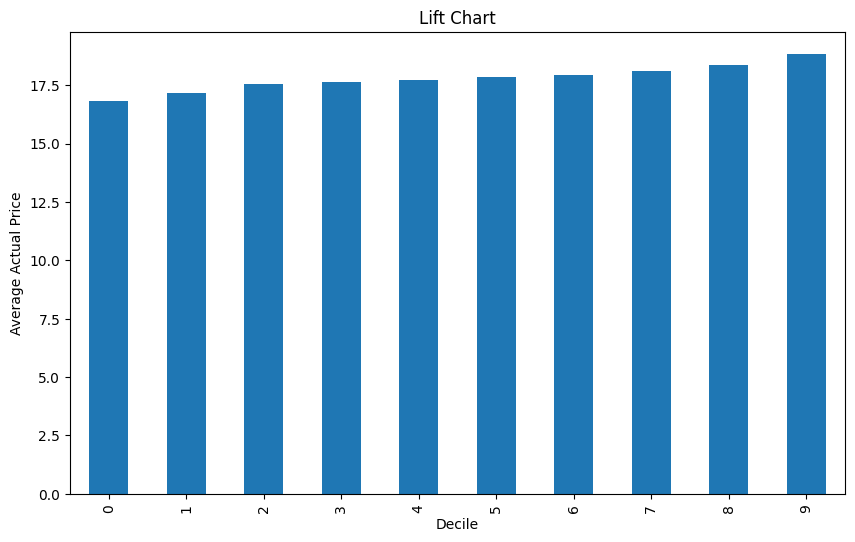

In [69]:
import matplotlib.pyplot as plt

# Plotting the lift chart
plt.figure(figsize=(10, 6))
lift.plot(kind='bar')
plt.title('Lift Chart')
plt.xlabel('Decile')
plt.ylabel('Average Actual Price')
plt.show()

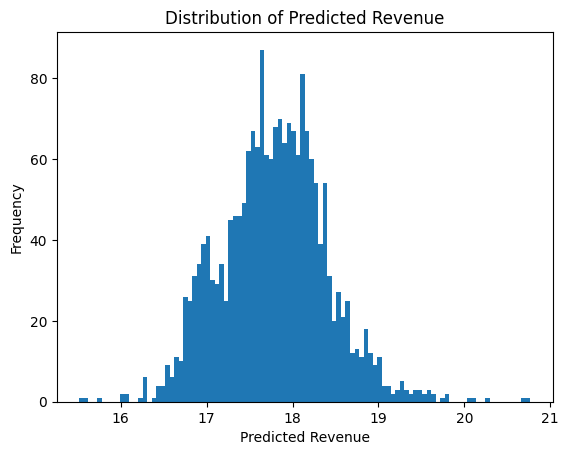

        count       mean       std        min        25%        50%  \
decile                                                                
0       197.0  16.740110  0.238180  15.519621  16.674964  16.815899   
1       197.0  17.116872  0.095151  16.965089  17.023324  17.104555   
2       196.0  17.388154  0.062350  17.281456  17.337063  17.392204   
3       197.0  17.567923  0.043584  17.492469  17.528378  17.567100   
4       197.0  17.713958  0.047746  17.638952  17.669996  17.710414   
5       196.0  17.871922  0.044477  17.798076  17.832815  17.867809   
6       197.0  18.026483  0.045144  17.952037  17.985689  18.027552   
7       196.0  18.173034  0.043616  18.104156  18.138196  18.167414   
8       197.0  18.369219  0.072093  18.256429  18.303816  18.366749   
9       197.0  18.902259  0.385677  18.523127  18.623991  18.808828   

              75%        max  
decile                        
0       16.894370  16.964749  
1       17.192656  17.281355  
2       17.440990  17.4

In [70]:
# Check the distribution of predicted values
plt.hist(y_pred, bins=100)
plt.xlabel('Predicted Revenue')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Revenue')
plt.show()

# Sort by predicted revenue
results = results.sort_values(by='predicted', ascending=False)

# Verify that deciles are distinct and contain varying predicted values
print(results.groupby('decile')['predicted'].describe())

# Calculate lift for each decile
baseline_average_revenue = y_val.mean()
results_grouped = results.groupby('decile').agg({
    'actual': ['mean', 'sum', 'count']
}).reset_index()
results_grouped.columns = ['decile', 'avg_actual', 'sum_actual', 'count']
results_grouped['lift'] = results_grouped['avg_actual'] / baseline_average_revenue

print(results_grouped[['decile', 'lift']])

In [71]:
results

,actual,predicted,decile
78101,20.497807,20.768453,9
15505,20.881525,20.695879,9
764560,23.605577,20.290566,9
664543,19.810295,20.119505,9
148508,14.498608,20.077791,9
...,...,...,...
59956,15.068274,16.034697,0
248851,14.503646,16.012969,0
512393,18.336973,15.747200,0
253746,18.459613,15.609581,0
